In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller, acf, q_stat
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy.stats as stats
import yfinance as yf
import pandas as pd
import numpy as np
import warnings
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
from dieboldmariano import dm_test

# Suppress warnings
warnings.filterwarnings('ignore')

In [2]:
# Daily data...
nasdaqD = yf.download('^IXIC', start='2001-01-01', end='2022-12-31', interval='1d')
nasdaqD = nasdaqD['Close'].dropna()

# Monthly data...
nasdaqM = yf.download('^IXIC', start='2001-01-01', end='2022-12-31', interval='1mo')
nasdaqM = nasdaqM['Close'].dropna()

## Price of the commodity 'gold'...
# Daily data...
goldD = yf.download('GC=F', start='2001-01-01', end='2022-12-31', interval='1d')
goldD = goldD['Close'].dropna()

# Monthly data...
goldM = yf.download('GC=F', start='2001-01-01', end='2022-12-31', interval='1mo')
goldM = goldM['Close'].dropna()

## Price of the cryptocurrency 'Ethereum'...
# Daily data...
ethD = yf.download('ETH-USD', start='2001-01-01', end='2022-12-31', interval='1d')
ethD = ethD['Close'].dropna()

# Monthly data...
ethM = yf.download('ETH-USD', start='2001-01-01', end='2022-12-31', interval='1mo')
ethM = ethM['Close'].dropna()

## Price of the energy commodity 'Brent Crude Oil'...
# Daily data...
brentD = yf.download('BZ=F', start='2001-01-01', end='2022-12-31', interval='1d')
brentD = brentD['Close'].dropna()

# Monthly data...
brentM = yf.download('BZ=F', start='2001-01-01', end='2022-12-31', interval='1mo')
brentM = brentM['Close'].dropna()

## Stock price of 'Leonardo Spa'...
# Daily data...
leonardoD = yf.download('LDO.MI', start='2001-01-01', end='2022-12-31', interval='1d')
leonardoD = leonardoD['Adj Close'].dropna()

# Monthly data...
leonardoM = yf.download('LDO.MI', start='2001-01-01', end='2022-12-31', interval='1mo')
leonardoM = leonardoM['Adj Close'].dropna()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
def analyze_time_series(series, name, frequency):
    # Check if the series is daily or monthly and adjust the plot title accordingly
    freq_title = "DAILY" if frequency == "daily" else "MONTHLY"

    # Set up the plot area
    fig, axes = plt.subplots(3, 2, figsize=(15, 10))
    fig.suptitle(f'{name} - {freq_title} DATA ANALYSIS', fontsize=16)

    # Time series plot
    axes[0, 0].plot(series)
    axes[0, 0].set_title(f'{name} - {freq_title} PRICES')

    # Log Prices
    log_series = np.log(series)
    axes[0, 1].plot(log_series)
    axes[0, 1].set_title(f'{name} - {freq_title} LOG PRICES')

    # Log Returns
    log_returns = log_series.diff().dropna()
    axes[1, 0].plot(log_returns)
    axes[1, 0].set_title(f'{name} - {freq_title} LOG RETURN')

    # Autocorrelation plots
    returns= series.diff().dropna()
    plot_acf(series, ax=axes[1, 1], lags=50, title='Autocorrelation - Prices')
    plot_acf(log_series, ax=axes[2, 0], lags=50, title='Autocorrelation - Log Prices')
    plot_acf(returns, ax=axes[2, 1], lags=50, title='Autocorrelation - Returns')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [4]:
def analyze_time_series2(series, name, frequency):
    freq_title = "DAILY" if frequency == "daily" else "MONTHLY"
    log_series = np.log(series)
    log_returns = log_series.diff().dropna()

    # Analysis of deviation from normality
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'{name} - {freq_title} DEVIATION FROM NORMALITY', fontsize=16)

    # Density plot
    sns.kdeplot(log_returns, ax=axes[0, 0])
    axes[0, 0].set_title(f'{name} - {freq_title} RETURNS DENSITY')
    
    # Q-Q plot
    stats.probplot(log_returns, dist="norm", plot=axes[0, 1])
    axes[0, 1].set_title('Normal Q-Q Plot')

    # Autocorrelation of Squared Returns
    plot_acf(log_returns, ax=axes[0, 2], lags=20, title='Autocorrelation - Log Returns')
    
    # Autocorrelation of Squared Returns
    squared_returns = log_returns ** 2
    axes[1, 0].plot(squared_returns)
    axes[1, 0].set_title(f'{name} - SQUARED LOG.RET')

    plot_acf(squared_returns, ax=axes[1, 1], lags=20, title='Autocorrelation - Squared Returns')
    plot_pacf(squared_returns, ax=axes[1, 2], lags=20, title='Partial Autocorrelation - Squared Returns')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [5]:
def ljung_box_test(series, lags=20):
    # Ljung-Box test
    lb_test = acorr_ljungbox(series, lags=[lags])
    print("Ljung-Box Test:")
    print(f"P-Value: {np.round(lb_test[1], 3)}")

In [6]:
def adf_test_with_lag_selection(series, max_lag):
    intercept_significant = False

    while max_lag > 0:
        # Differencing the series
        diff_series = series.diff().dropna()

        # Constructing the lagged data
        lagged_data = pd.concat([diff_series.shift(i) for i in range(1, max_lag + 1)], axis=1)
        lagged_data.columns = [f'y.lag.{i}' for i in range(1, max_lag + 1)]
        lagged_data['diff_series'] = diff_series
        lagged_data = lagged_data.dropna()

        # Fitting the linear model with a constant
        model = sm.OLS(lagged_data['diff_series'], sm.add_constant(lagged_data.drop('diff_series', axis=1)))
        result = model.fit()

        # Getting the p-value of the last lag
        p_value_last_lag = result.pvalues[f'y.lag.{max_lag}']

        # Check significance of the intercept
        intercept_significant = result.pvalues['const'] < 0.05

        if p_value_last_lag < 0.05:
            break

        max_lag -= 1

    return result, max_lag, intercept_significant

In [7]:
# Function for ADF Test with optimal lag and intercept option
def adf_test(series, lag, intercept_significant):
    regression = 'c' if intercept_significant else 'n'
    result = adfuller(series, maxlag=lag, regression=regression)
    return result

In [8]:
def fit_arma_and_return_coefficients(series, ar_order, ma_order):
    # Fit the ARMA model using ARIMA with d=0
    model = ARIMA(series, order=(ar_order, 0, ma_order))
    results = model.fit()

    # Get the coefficients and their standard errors
    coeffs = results.params
    stderr = results.bse
    t_values = coeffs / stderr

    # Creating a DataFrame to display coefficients and their significance
    coef_summary = pd.DataFrame({
        'Coefficient': coeffs,
        'Standard Error': stderr,
        't-value': t_values
    })

    return coef_summary

In [9]:
def forecast_and_calculate_errors(series, forecast_length, AR, MA):
    n = len(series)
    train_data = series[:n - forecast_length]
    test_data = series[n - forecast_length:]

    # Fit ARIMA model
    model = ARIMA(train_data, order=(AR, 0, MA))
    fitted_model = model.fit()

    # Forecast
    forecast = fitted_model.forecast(steps=forecast_length)
    
    series1 = forecast

    # Series 2: Mean - Observed
    mean_train_data = np.mean(train_data)
    series2 = [mean_train_data for _ in range(forecast_length)]


    return series1, series2, test_data, forecast

In [10]:
def acfs(series, lag, start):
    log_series = np.log(series).dropna()
    log_returns = log_series.diff().dropna()

    # Calculate ACF and PACF
    acf_values = acf(log_returns, nlags=lag)
    pacf_values = pacf(log_returns, nlags=lag)

    fig, axes = plt.subplots(2, 1, figsize=(12, 8))

    # Autocorrelation plot
    plot_acf(log_returns, lags=lag, ax=axes[0], title='Autocorrelation - Log Returns', zero=False)
    axes[0].set_xlim([start-1, lag])
    axes[0].set_ylim([min(acf_values[start-1:]), max(acf_values[start-1:])])  # Adjust y-axis

    # Partial autocorrelation plot
    plot_pacf(log_returns, lags=lag, ax=axes[1], title='Partial Autocorrelation - Log Returns', zero=False)
    axes[1].set_xlim([start-1, lag])
    axes[1].set_ylim([min(pacf_values[start-1:]), max(pacf_values[start-1:])])  # Adjust y-axis

    plt.tight_layout()
    plt.show()

# Ideal acf and pacf for AR(1), MA(1), ARMA(1,1)

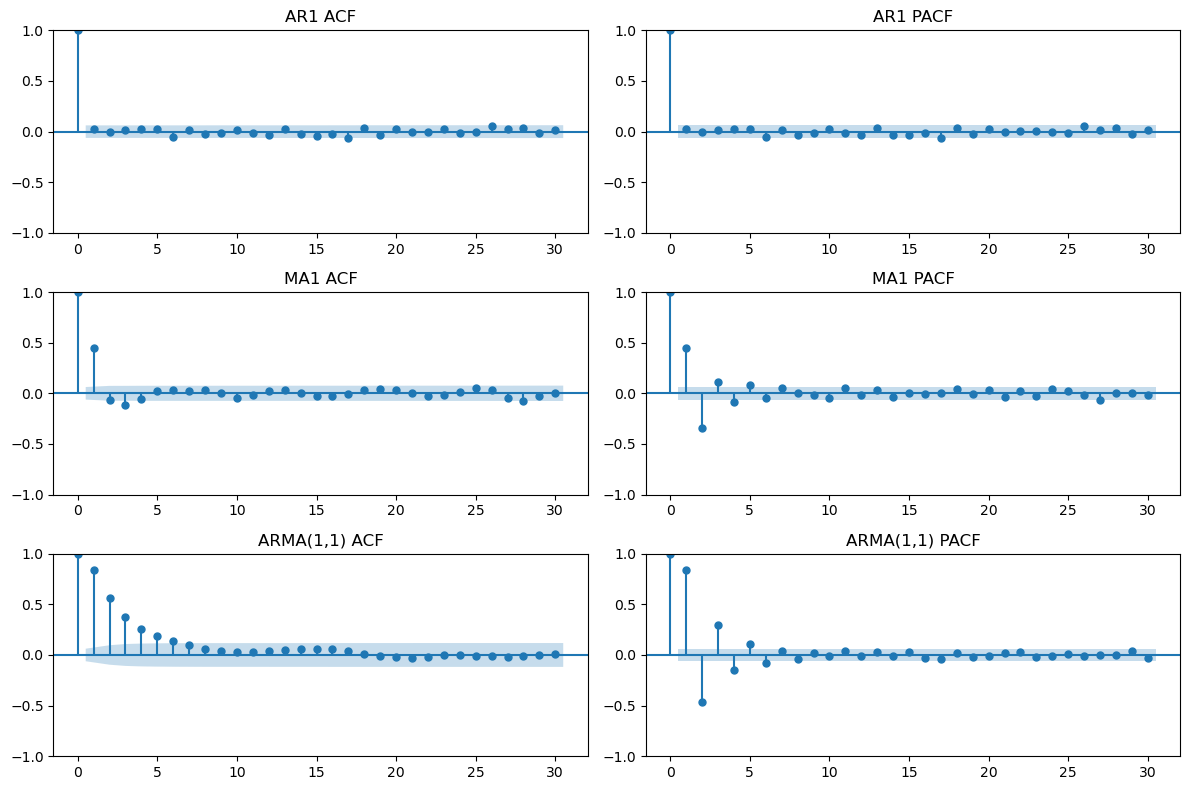

In [31]:
# Set a random seed for reproducibility
np.random.seed(123)

# AR1 model: AR parameter = 0.7
ar1 = np.array([0.7])
ma1 = np.array([0.7])
AR1_process = ArmaProcess(ar1, ma1)
AR1_data = AR1_process.generate_sample(nsample=1000)

# MA1 model: MA parameter = 0.7
ar2 = np.array([1])
ma2 = np.array([1, 0.7])
MA1_process = ArmaProcess(ar2, ma2)
MA1_data = MA1_process.generate_sample(nsample=1000)

# ARMA(1,1) model: AR parameter = 0.7, MA parameter = 0.7
ar3 = np.array([1, -0.7])
ma3 = np.array([1, 0.7])
ARMA11_process = ArmaProcess(ar3, ma3)
ARMA11_data = ARMA11_process.generate_sample(nsample=1000)

# Plotting the ACF and PACF
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

# AR1 model ACF and PACF
plot_acf(AR1_data, ax=axes[0, 0], title="AR1 ACF")
plot_pacf(AR1_data, ax=axes[0, 1], title="AR1 PACF")

# MA1 model ACF and PACF
plot_acf(MA1_data, ax=axes[1, 0], title="MA1 ACF")
plot_pacf(MA1_data, ax=axes[1, 1], title="MA1 PACF")

# ARMA(1,1) model ACF and PACF
plot_acf(ARMA11_data, ax=axes[2, 0], title="ARMA(1,1) ACF")
plot_pacf(ARMA11_data, ax=axes[2, 1], title="ARMA(1,1) PACF")

plt.tight_layout()
plt.show()

### ARMA(1,1) with parameters 0.7 and 0.7

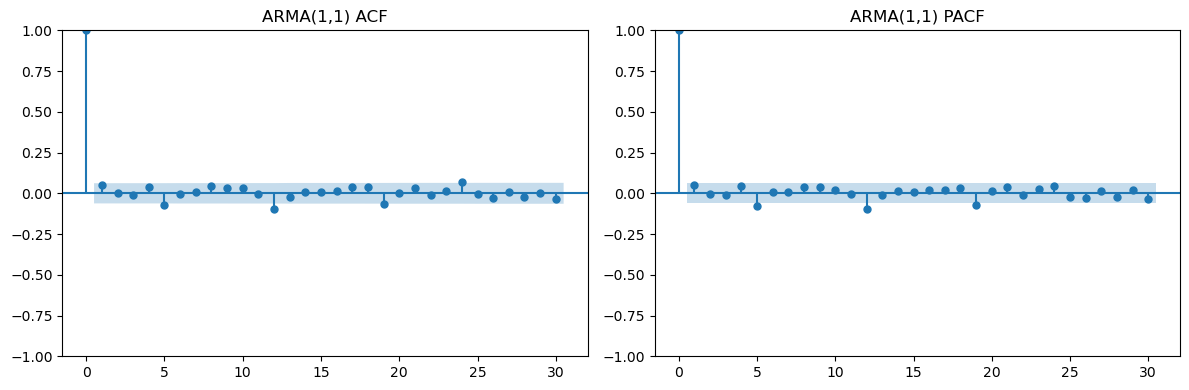

In [12]:
# ARMA(1,1) model: AR parameter = 0.7, MA parameter = 0.7
ar3 = np.array([1, 0.7])
ma3 = np.array([1, 0.7])
ARMA11_process = ArmaProcess(ar3, ma3)
ARMA11_data = ARMA11_process.generate_sample(nsample=1000)

# Plotting the ACF and PACF for ARMA(1,1) model
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Adjusting for a single row with two columns
plot_acf(ARMA11_data, ax=axes[0], title="ARMA(1,1) ACF")
plot_pacf(ARMA11_data, ax=axes[1], title="ARMA(1,1) PACF")

plt.tight_layout()
plt.show()

### ARMA(1,1) with parameters 0.7 and -0.7

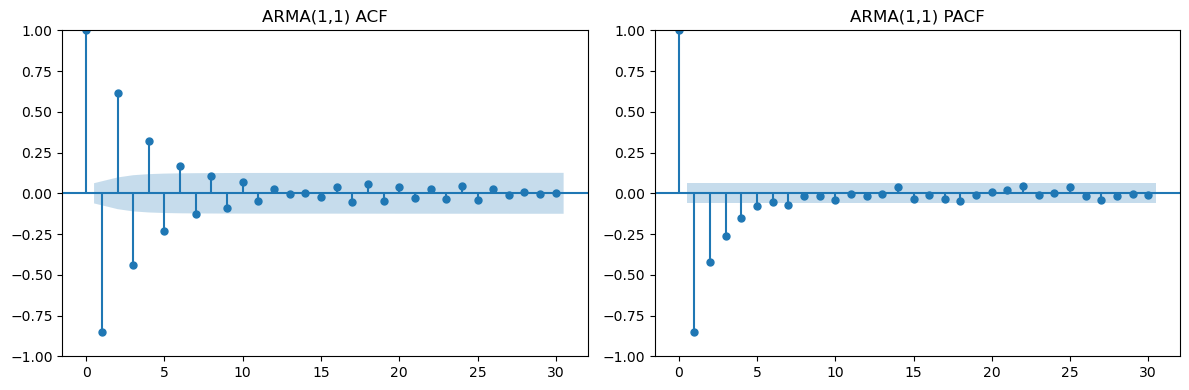

In [13]:
# ARMA(1,1) model: AR parameter = 0.7, MA parameter = 0.7
ar3 = np.array([1, 0.7])
ma3 = np.array([1, -0.7])
ARMA11_process = ArmaProcess(ar3, ma3)
ARMA11_data = ARMA11_process.generate_sample(nsample=1000)

# Plotting the ACF and PACF for ARMA(1,1) model
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Adjusting for a single row with two columns
plot_acf(ARMA11_data, ax=axes[0], title="ARMA(1,1) ACF")
plot_pacf(ARMA11_data, ax=axes[1], title="ARMA(1,1) PACF")

plt.tight_layout()
plt.show()

### ARMA(1,1) with parameters -0.7 and 0.7

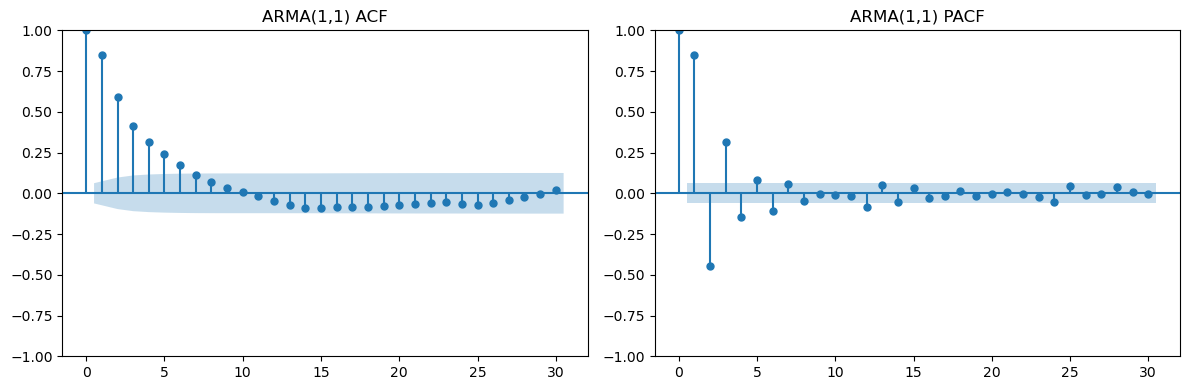

In [14]:
# ARMA(1,1) model: AR parameter = 0.7, MA parameter = 0.7
ar3 = np.array([1, -0.7])
ma3 = np.array([1, 0.7])
ARMA11_process = ArmaProcess(ar3, ma3)
ARMA11_data = ARMA11_process.generate_sample(nsample=1000)

# Plotting the ACF and PACF for ARMA(1,1) model
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Adjusting for a single row with two columns
plot_acf(ARMA11_data, ax=axes[0], title="ARMA(1,1) ACF")
plot_pacf(ARMA11_data, ax=axes[1], title="ARMA(1,1) PACF")

plt.tight_layout()
plt.show()

# Nasdaq Daily Data

In the following figures, graphical analyses of the series are provided (from left to right: daily prices, daily log-prices, and log-returns) along with their corresponding correlograms. A strong upward trend is clearly identifiable in the stock index over the considered time interval, as well as volatility clustering behavior (more evidently observable in the log-returns series), where periods of high (persistent) volatility are followed by periods of low volatility. Regarding the overall autocorrelations (ACF), as per theory, there is clear evidence of the non-stationarity of the stochastic process; whereas, in the log-returns, even though there are statistically significant values (due to the large size of the series), these can be considered almost negligible. This indicates an economic insignificance in the correlation of the data

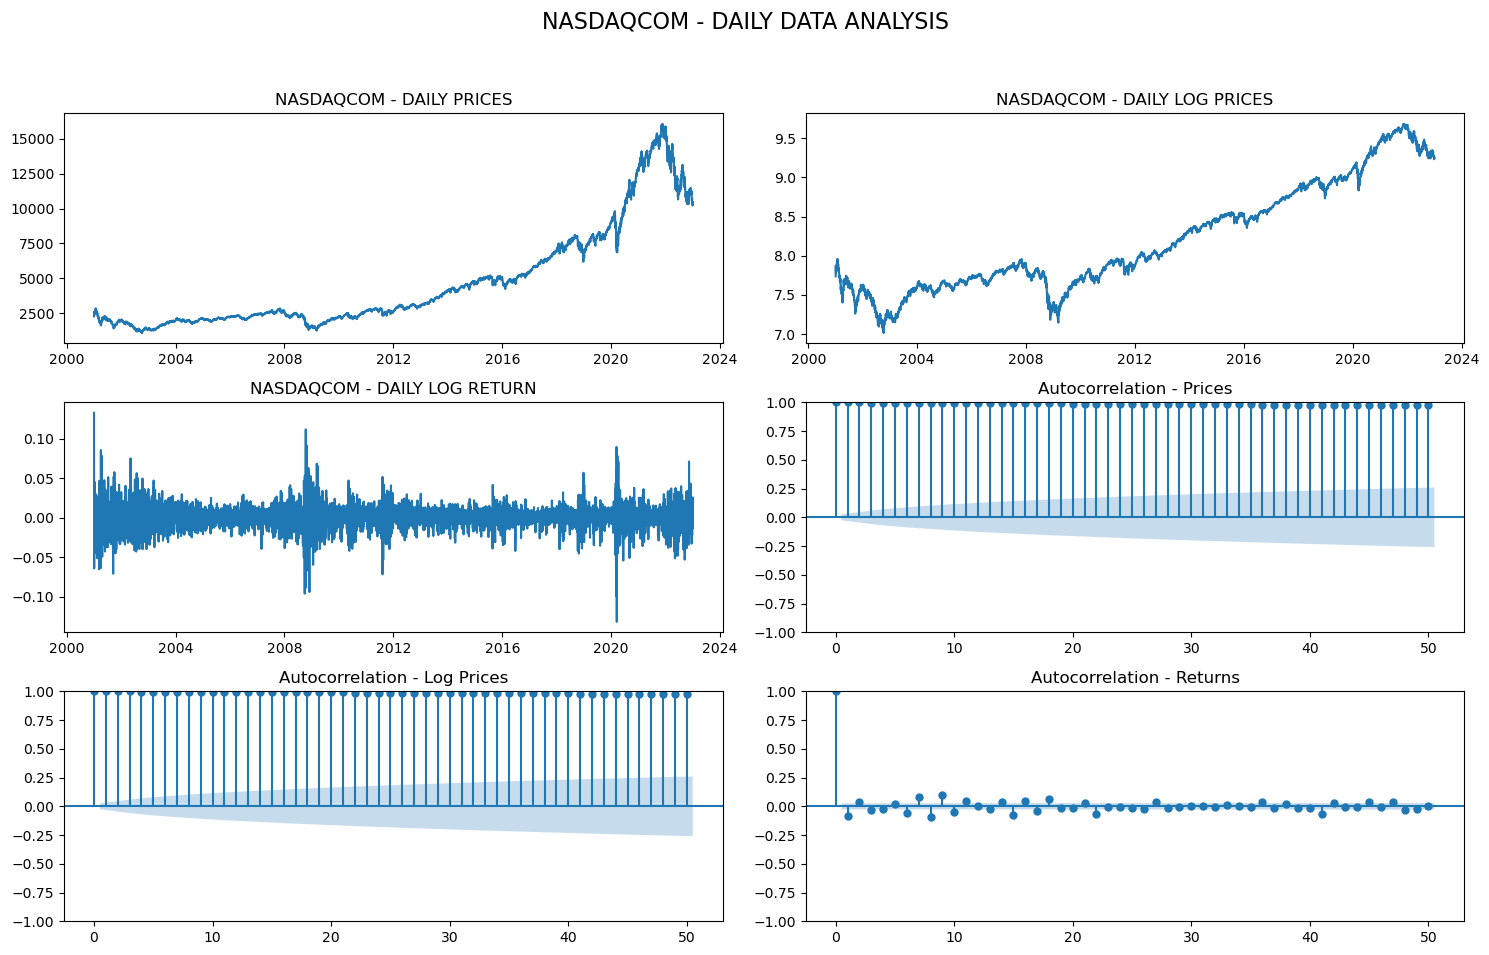

In [15]:
analyze_time_series(nasdaqD, 'NASDAQCOM', 'daily')

In this case, the figure illustrates several typical characteristics of a financial instrument that are worth analyzing individually: the empirical hypothesis of non-normality of the historical series is confirmed; particularly due to strong kurtosis, which we can assert is present due to very thick tails. The skewness, another empirical characteristic, for a stock index like the NASDAQ, which contains thousands of quotations within it, seems to almost approach nullity.

In the second group of figures, at the bottom, a proxy for variance (i.e., a series of the squares of the returns) is analyzed: it is also observable in this case that the levels of variability (on which subsequently models that can estimate it will be built) are not always constant and instead suggest a sort of serial dependence, confirmed quite clearly by the ACF of the squared returns.

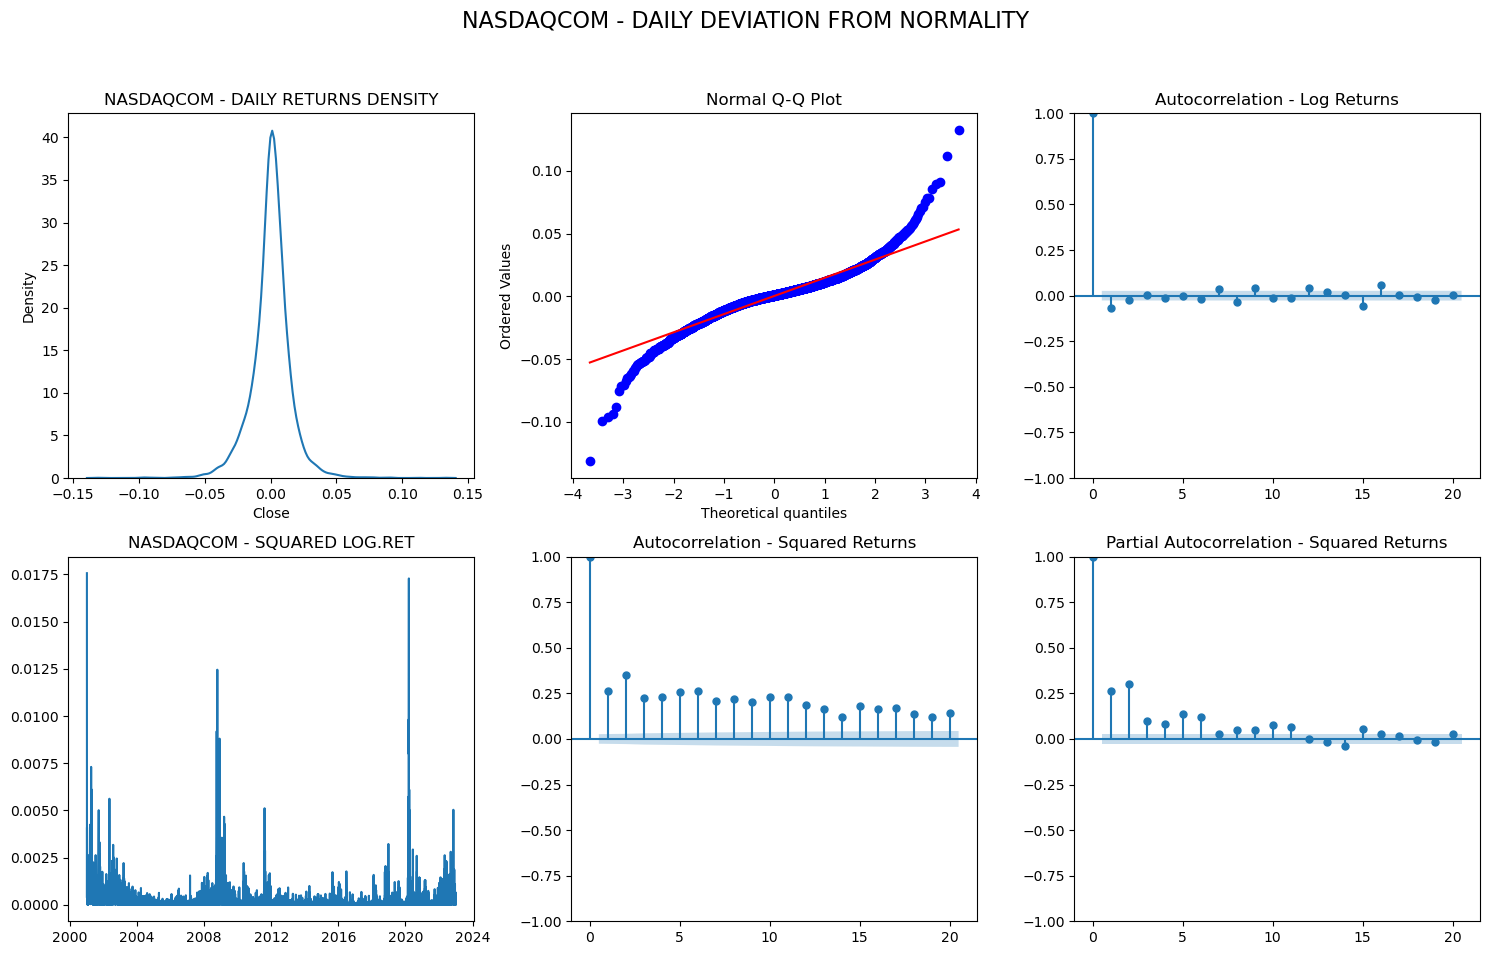

In [16]:
analyze_time_series2(nasdaqD, 'NASDAQCOM', 'daily')

In [17]:
log_nasdaqD = np.log(nasdaqD)

# Find the optimal lag and check intercept significance
_, selected_lag, intercept_is_significant = adf_test_with_lag_selection(log_nasdaqD, 21)

# Run the ADF test with the determined parameters
adf_result = adf_test(log_nasdaqD, selected_lag, intercept_is_significant)

print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Used max lag: {selected_lag}")
print(f"Regression option: {'with intercept' if intercept_is_significant else 'without intercept'}")


ADF Statistic: 1.2343789029956178
p-value: 0.9440933778943712
Used max lag: 19
Regression option: without intercept


Plotting the autocorrelations from lag 2 onwards we don't see a particular pattern in the acf and pacf

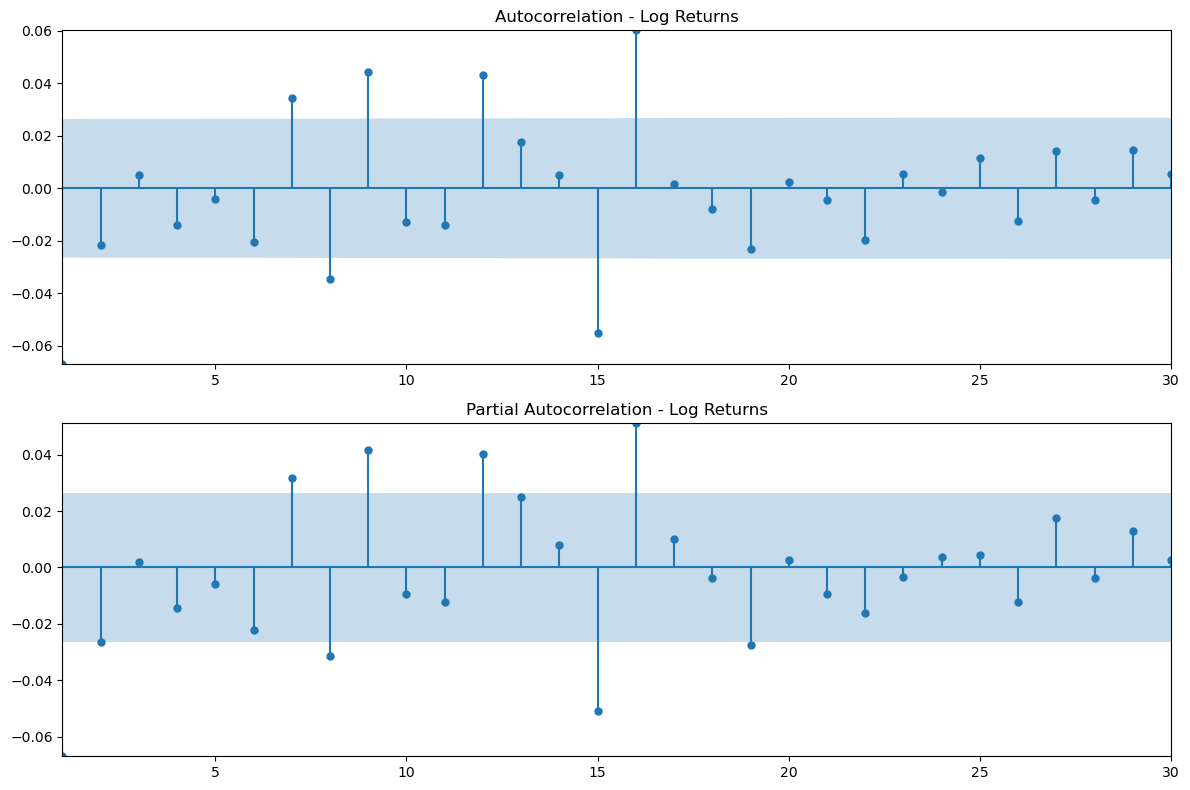

In [18]:
acfs(nasdaqD,30,2)

The observation that the coefficients of the Autoregressive (AR) part of an ARMA model are similar in magnitude but opposite in sign to those of the Moving Average (MA) part suggests a specific dynamic in the time series that can influence model and simplification.

In an ARMA model, the AR part captures the momentum or persistence of the series, meaning how past values influence current values. The MA part, on the other hand, captures the shock or noise effects, reflecting how past errors (unexpected changes or shocks in the series) influence current values.

When AR and MA coefficients are similar but with opposite signs, it often indicates that the effects captured by the AR and MA components may be offsetting each other. 

In [19]:
log_series = np.log(nasdaqD).dropna()
log_returns = log_series.diff().dropna()
fit_arma_and_return_coefficients(log_returns[0:(len(log_returns)-365)], 1, 1)

,Coefficient,Standard Error,t-value
const,0.000354,0.000196,1.804408
ar.L1,0.126534,0.089289,1.417133
ma.L1,-0.199906,0.089469,-2.234348
sigma2,0.000218,0.000002,106.008808


### Diebold-Mariano (DM) Test Overview

The Diebold-Mariano (DM) test compares the predictive accuracy of two forecasting models. It calculates the forecast errors for each model and then computes the loss differential series, the difference between the squared errors of the two models.

#### Key Points:
- **Test Statistic:** The mean of the loss differential, standardized to follow a standard normal distribution (`N(0,1)`).
- **Application:** Used here to compare `series1` (forecasts from an ARIMA model) and `series2` (naive mean forecast model).
- **Interpretation:** A significant DM test statistic indicates a significant difference in predictive accuracy between the two models. `one_sided=False` tests for any difference without assuming which model is better.

The test statistic being close to zero and the high p-value together suggest that there is no statistical evidence to conclude that there is a significant difference in the predictive accuracy of the two forecasting models being compared.

In [20]:
series1, series2, test_data, forecast = forecast_and_calculate_errors(log_returns, 365,1,0)
dm_test(test_data.values, series1,series2, one_sided= False)

(-0.04551047572236049, 0.9637253819385414)

# Gold Daily Data

In the following chart, graphical analyses of the series are presented, including daily prices, daily logarithmic prices, and logarithmic returns, along with their corresponding correlograms. Observations from the chart include:

1. **Gold Prices Trend:** Until the subprime mortgage crisis in 2008, gold exhibited a strong bullish trend. Following this period, it underwent a significant bearish phase before stabilizing, which is typical for gold, often considered a safe-haven asset during unstable and inflationary periods.

2. **Volatility Clustering:** Particularly noticeable in the series of logarithmic returns is a pattern of volatility clustering. This pattern indicates periods of high (persistent) volatility followed by periods of low volatility, a common characteristic in financial time series.

3. **Autocorrelation (ACF):** The global autocorrelations (ACF) confirm the non-stationarity of the stochastic process, as expected from theory. Although some statistically significant values are observed in the logarithmic returns due to the large size of the series, these can be considered almost negligible. This implies that the data show an economically insignificant correlation, which is also supported by the Ljung-Box test.

Overall, the chart provides insightful analysis into the behavior of gold prices and their statistical properties, highlighting trends, volatility patterns, and autocorrelation characteristics in different phases of the market.

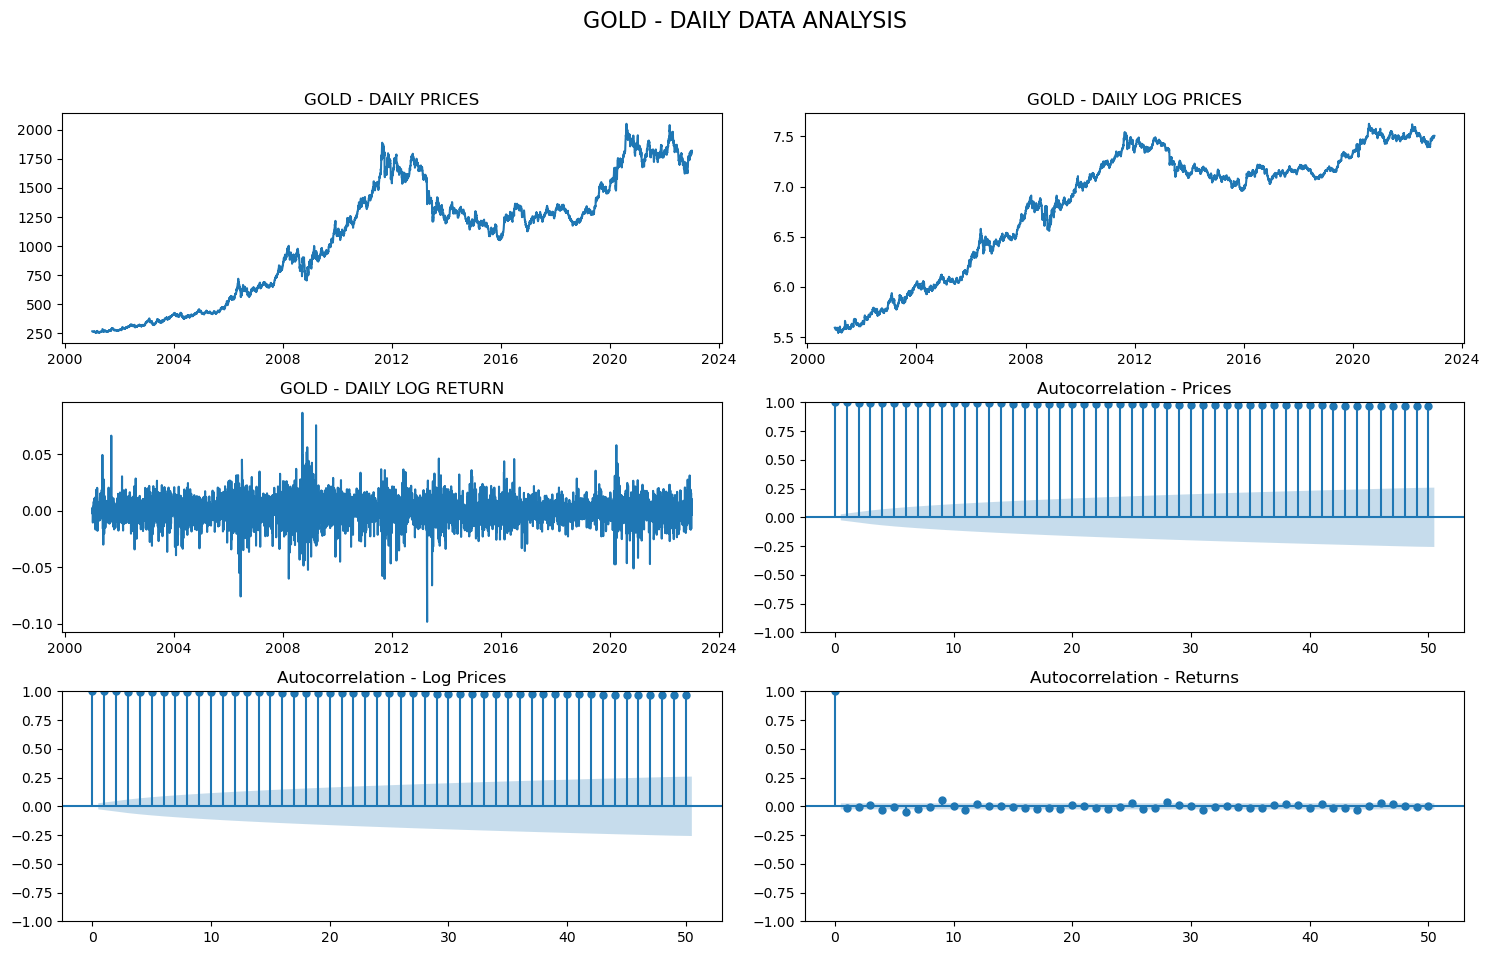

In [21]:
analyze_time_series(goldD, 'GOLD', 'daily')

The empirical hypothesis of non-normality in the historical series is confirmed. This is particularly due to a high kurtosis, evident from the presence of thick tails in the distribution. Asymmetry, another empirical characteristic, shows a more distinct deviation from normality compared to what is observed in the NASDAQ index.

In the second group of figures, located at the bottom, there is also observable evidence that the levels of variability (upon which subsequent models aiming to estimate it are based) are not constant. This suggests a kind of serial dependence, which is almost clearly confirmed by the Autocorrelation Function (ACF) of the squared returns.



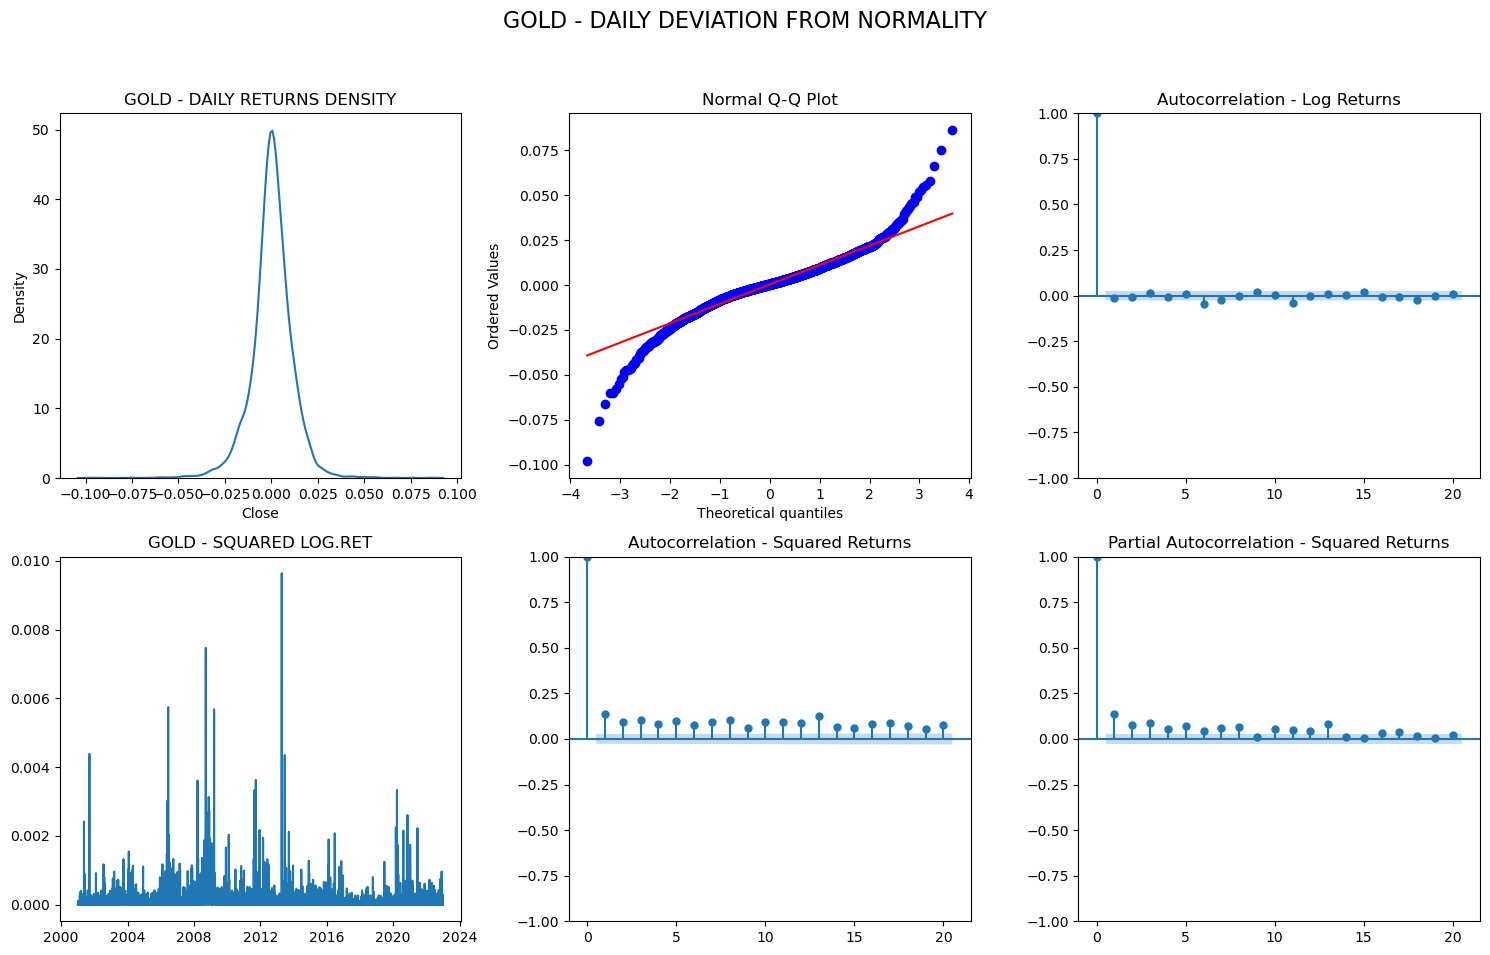

In [22]:
analyze_time_series2(goldD, 'GOLD', 'daily')

### Test for the presence of Unit Root

As expected, the test results indicate that there is not enough evidence to reject the null hypothesis. The existence of a single unit root aligns with the typical behavior of many financial time series, where a series is non-stationary in its level but becomes stationary after differencing.

If the test on the first difference confirms the presence of only one unit root, it supports the notion of market efficiency for this particular series. Market efficiency hypothesis implies that asset prices fully reflect all available information, and thus, any predictable patterns in price changes are absent. On the contrary, if multiple unit roots are found, it could suggest violations of the market efficiency hypothesis, indicating that the series may contain predictable components or trends, which is generally not expected in an efficient market.

In [23]:
log_goldD = np.log(goldD)

# Find the optimal lag and check intercept significance
_, selected_lag, intercept_is_significant = adf_test_with_lag_selection(log_goldD, 21)

# Run the ADF test with the determined parameters
adf_result = adf_test(log_goldD, selected_lag, intercept_is_significant)

print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Used max lag: {selected_lag}")
print(f"Regression option: {'with intercept' if intercept_is_significant else 'without intercept'}")


ADF Statistic: -1.9159434349382998
p-value: 0.3245983863324387
Used max lag: 11
Regression option: with intercept


### Test for the presence of Unit Root in the first differences

The analysis focuses on testing the hypothesis of non-stationarity within first differences, particularly in the context of returns. It is expected that the null hypothesis, which assumes the presence of non-stationarity, would be clearly rejected for these returns.

Consistent with these expectations, the null hypothesis of non-stationarity is rejected. This outcome signifies that the log-returns are stationary, indicating no underlying trends or patterns affecting their statistical properties over time. In contrast, log-prices are determined to be non-stationary, suggesting the presence of trends or seasonal effects in their time series data.

In [24]:
log_goldD = np.log(goldD)

# Calculate the first differences of the log-transformed series
log_diff_goldD = log_goldD.diff().dropna()

# Find the optimal lag and check intercept significance
_, selected_lag, intercept_is_significant = adf_test_with_lag_selection(log_diff_goldD, 21)

# Run the ADF test with the determined parameters
adf_result = adf_test(log_diff_goldD, selected_lag, intercept_is_significant)

print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Used max lag: {selected_lag}")
print(f"Regression option: {'with intercept' if intercept_is_significant else 'without intercept'}")

ADF Statistic: -23.66940632142756
p-value: 0.0
Used max lag: 21
Regression option: without intercept


Plotting the autocorrelations from lag 2 onwards we don't see a particular pattern in the acf and pacf

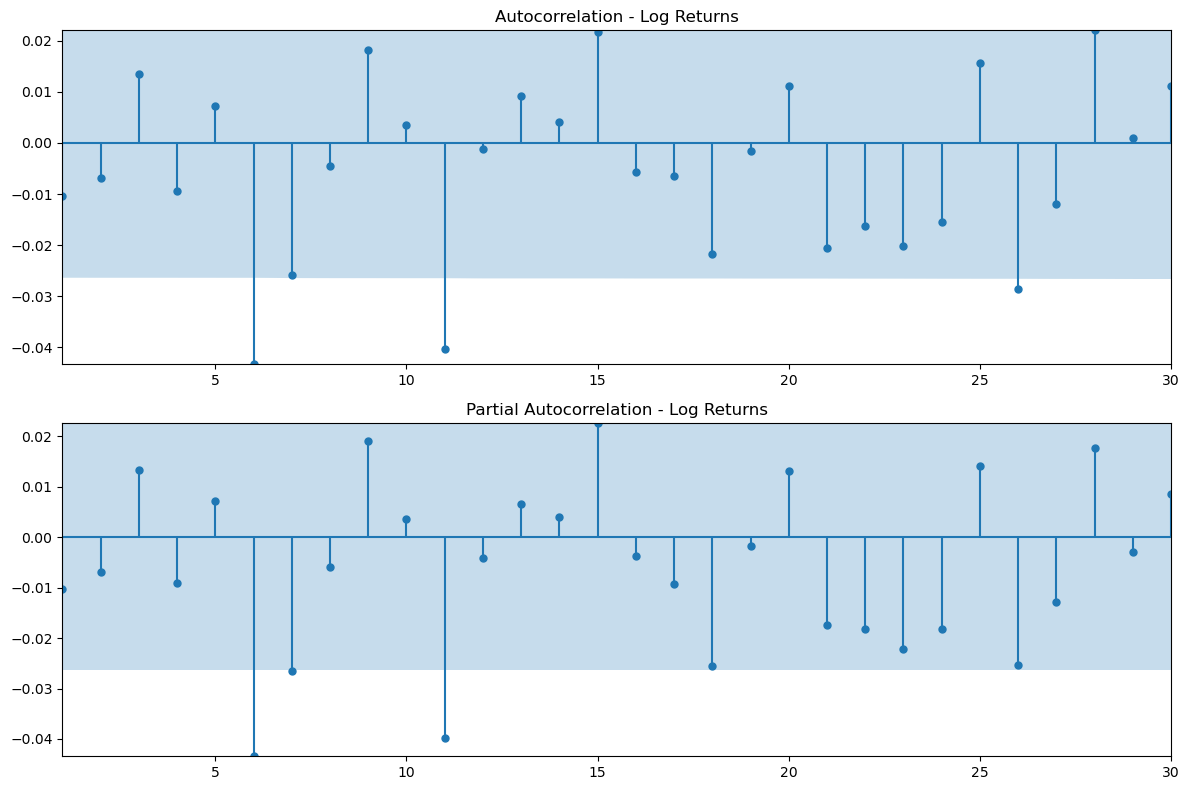

In [25]:
acfs(goldD,30,2)

The code fits an ARMA(1,1) model to the logarithmic returns, excluding the last 365 observations, and prints the model's coefficients.

The observation that the coefficients of the Autoregressive (AR) part of an ARMA model are similar in magnitude but opposite in sign to those of the Moving Average (MA) part suggests a specific dynamic in the time series that can influence model and simplification.

In an ARMA model, the AR part captures the momentum or persistence of the series, meaning how past values influence current values. The MA part, on the other hand, captures the shock or noise effects, reflecting how past errors (unexpected changes or shocks in the series) influence current values.

When AR and MA coefficients are similar but with opposite signs, it often indicates that the effects captured by the AR and MA components may be offsetting each other. 

In [26]:
# Convert the 'goldD' series to logarithmic scale and remove any missing values
log_series = np.log(goldD).dropna()

# Calculate the daily logarithmic returns by differencing the log series
log_returns = log_series.diff().dropna()

# Fit an ARMA(1,1) model to the logarithmic returns, excluding the last 365 days, and return the model coefficients
fit_arma_and_return_coefficients(log_returns[0:(len(log_returns)-365)], 1, 1)

,Coefficient,Standard Error,t-value
const,0.000368,0.000156,2.359762
ar.L1,-0.085183,1.193003,-0.071402
ma.L1,0.076048,1.193503,0.063718
sigma2,0.000125,0.000001,96.350852


In [27]:
series1, series2, test_data, forecast = forecast_and_calculate_errors(log_returns, 365,1,0)
dm_test(test_data.values, series1,series2, one_sided= False)

(-1.042684214407793, 0.2977865723110036)

# Ethereum daily data

In the following figure, graphical analyses are presented for the series, including daily prices, daily logarithmic prices, and logarithmic returns, along with their respective correlograms. 

Notably, there was a bullish trend in 2017, elevating the value of one ETH to around $1400 at the beginning of 2018. However, the cryptocurrency market subsequently experienced a significant correction, leading to a decrease in ETH prices. 

From 2020 onwards, the price began to rise again, only to fall from the end of 2021. This period demonstrates the non-constant behavior of the stock index over time, accompanied by volatility clustering (more evident in the logarithmic returns series). This clustering shows consistent volatility with spikes during events like the onset of the pandemic and mid-2021. Regarding the global autocorrelations (ACF), the data supports the hypothesis of non-stationarity in the stochastic process. However, in the logarithmic returns, despite some statistically significant values (due to the series' large amplitude), these can be considered almost negligible.

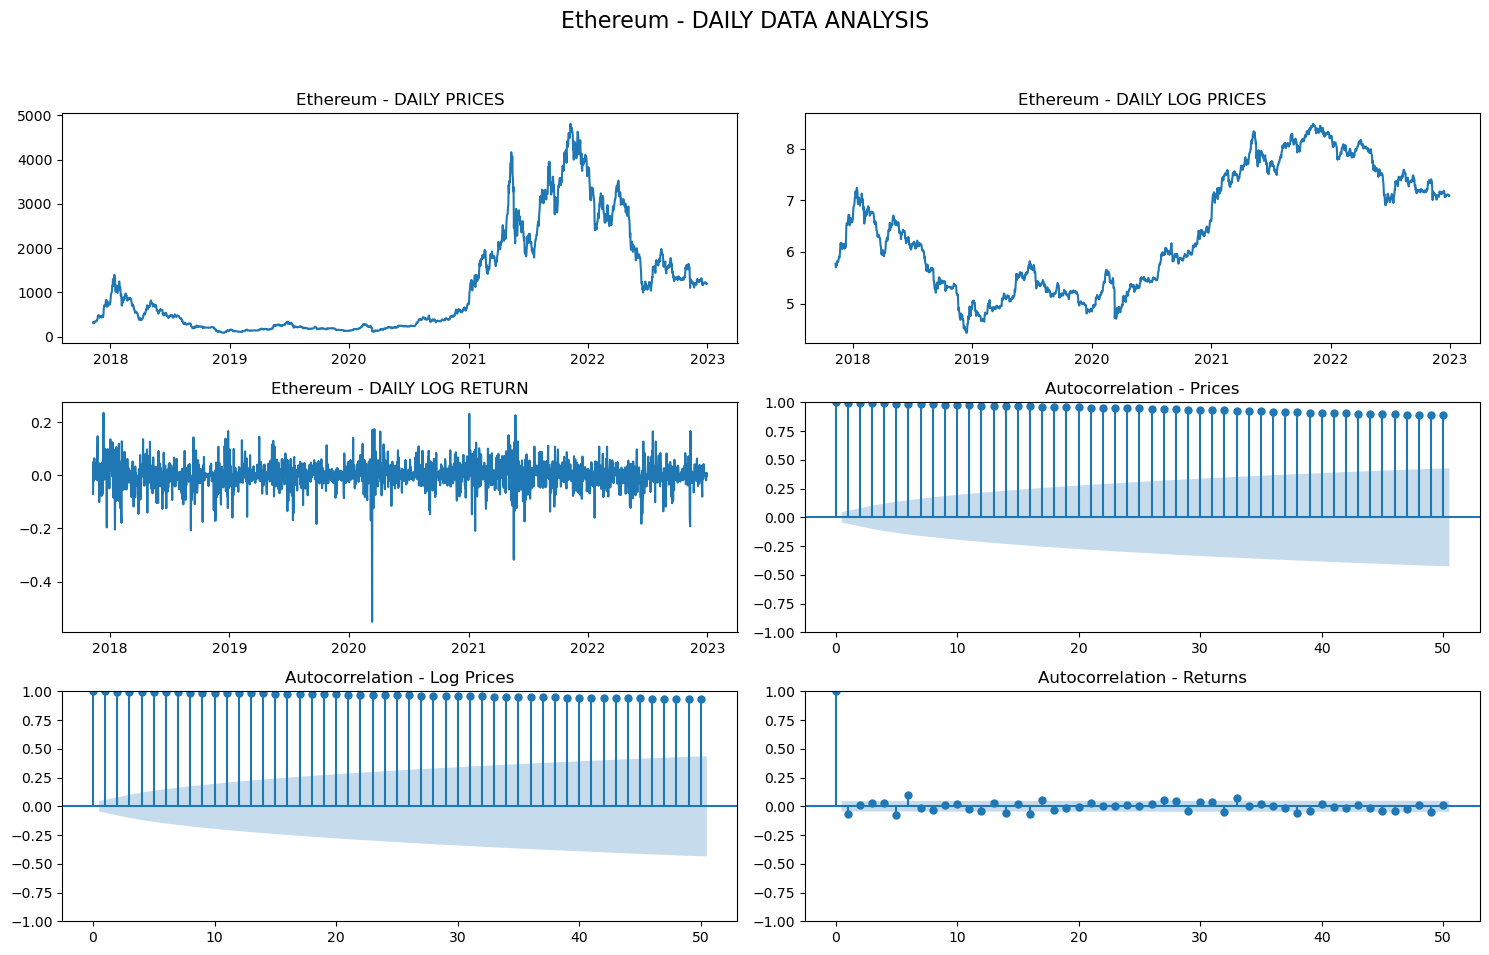

In [28]:
analyze_time_series(ethD, 'Ethereum', 'daily')

The following chart confirms the empirical hypothesis of non-normality in the historical series, particularly due to high kurtosis, as indicated by the presence of thick tails. Additionally, the analysis of skewness reveals a negative asymmetry for Ethereum, evident in the probability distribution graph, which shows heavier left tails. 

In the second set of figures, located at the bottom, a proxy for variance (the series of squared returns) is analysed. Both the Autocorrelation Function (ACF) and the Partial Autocorrelation Function (PACF) do not show significant evidence of serial dependence. There might be a slight indication in the PACF, but it is minimal, given the values of the partial autocorrelations.

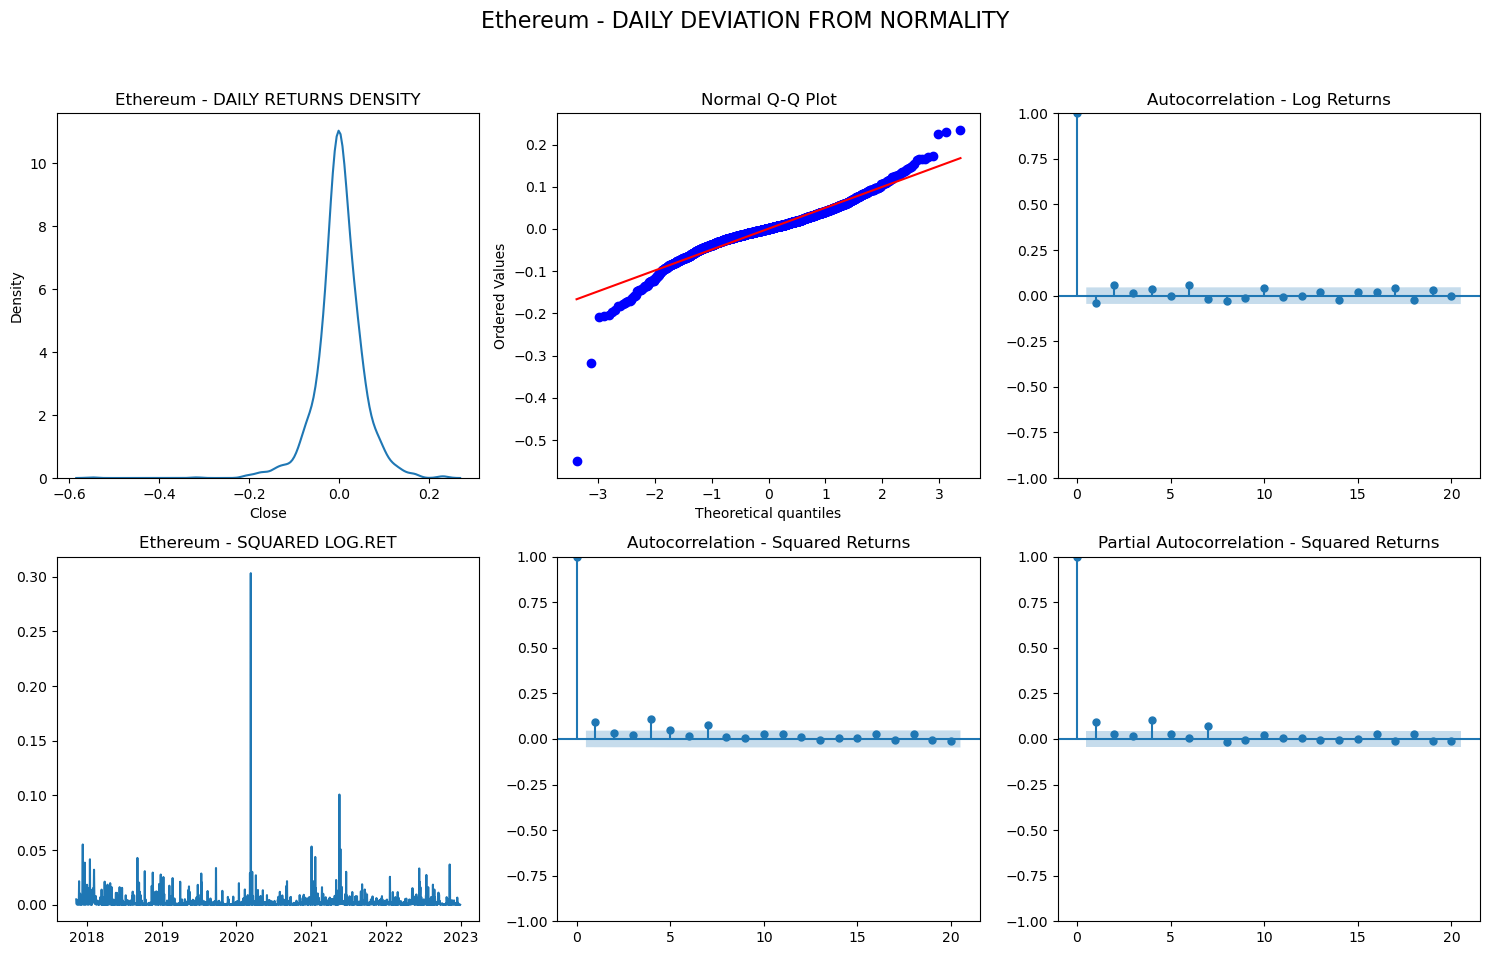

In [29]:
analyze_time_series2(ethD, 'Ethereum', 'daily')